<a href="https://colab.research.google.com/github/Kaliban-86/AndroidHomeworksRep/blob/master/%D0%94%D0%97_Lite_%7C_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. На основе учебного ноутбука проведите финальную подготовку данных. Иизмените количество сегментирующих классов с `16` на `5`.

2. Проведите суммарно не менее `10` экспериментов и визуализируйте их результаты (включая точность обучения сетей на одинаковом количестве эпох, например, на `7`):

  - изменив `filters` в сверточных слоях
  - изменив `kernel_size` в сверточных слоях
  - изменив активационную функцию в скрытых слоях с `relu` на `linear` или/и `selu`, `elu`.


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения. 

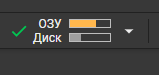



Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка 

### Импорт библиотек

In [ ]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt 

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image 

# Импортируем библиотеку numpy
import numpy as np 

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами 
import os 

# Для генерации случайных чисел 
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image 

# очистка ОЗУ
import gc 

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака

#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

!unzip -q 'construction_256x192.zip' # распоковываем архив

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip
To: /content/construction_512x384.zip
100%|██████████| 764M/764M [00:36<00:00, 21.0MB/s]


replace val/original/val_original_image_00000.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# Глобальные параметры

IMG_WIDTH = 192               # Ширина картинки 
IMG_HEIGHT = 256              # Высота картинки 
NUM_CLASSES = 16              # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

Загрузим оригинальные изображения (код из лекции):

In [ ]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути  
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):   
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))               
    
# Отображаем время загрузки картинок обучающей выборки    
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 

# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images)) 

cur_time = time.time() # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size   
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename), 
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))  

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 

# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images)) 

Обучающая выборка загружена. Время загрузки: 0.27c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.02c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути     
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size  
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))                                                     
    
# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments)) 

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename), 
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))  

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments)) 

Обучающая выборка загружена. Время загрузки: 0.24c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.02c
Количество изображений:  100


## Решение


In [ ]:
# Ваше решение

In [ ]:
FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)

CLASSES = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

In [ ]:
gc.collect()

187

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
xVal = [] # Создаем пустой список под проверочную выборку

for img in train_images: # Проходим по всем изображениям из train_images
  # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  x = image.img_to_array(img) 
  xTrain.append(x) # Добавляем очередной элемент в xTrain

for img in val_images: # Проходим по всем изображениям из val_images
  # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  x = image.img_to_array(img) 
  xVal.append(x) # Добавляем очередной элемент в xTrain

xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размер xTrain

xVal = np.array(xVal) # Переводим в numpy
print(xVal.shape) # Размер xVal

(1900, 192, 256, 3)
(100, 192, 256, 3)


In [ ]:
def segment2channel(data):

  y_result = []
  
  for d in data: # берем RGB картику
    sample = np.array(d)
    # создаем пустую 1-канальную картику
    y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1)).astype('int')
    
    for i, cl in enumerate(CLASSES): # берем класс и номер класса
      # сравниваем 3-х канальный  пиксель и класс и присваиваем номер класса
      y[np.where(np.all(sample==CLASSES[i], axis=-1))] = i 
    y_result.append(y)
  
  return np.array(y_result)

In [ ]:
def channel2segment(data):

  result = []

  for y in data: # берем 1-канальную картинку
    # создаем пустую 3х канальную картику
    temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3)).astype('int') 
    
    for i, cl in enumerate(CLASSES): # берем класс и номер класса
      # сравниваем, заполняем 3 канала значением из CLASSES[i]
      temp[np.where(np.all(y==i, axis=-1))] = CLASSES[i]
    result.append(temp)
  
  return np.array(result)

In [ ]:
yTrain = segment2channel(train_segments)
yVal = segment2channel(val_segments)

print(yTrain.shape)
print(yVal.shape)

(1900, 192, 256, 1)
(100, 192, 256, 1)


In [ ]:
gc.collect()

140

In [ ]:
yTrain5 = yTrain.copy()
yTrain5[(yTrain5 > 2) & (yTrain5 != 12)] = 3
yTrain5[yTrain5==12] = 4

yVal5 = yVal.copy()
yVal5[(yVal5 > 2) & (yVal5 != 12)] = 3
yVal5[yVal5==12] = 4

NUM_CLASSES = 5 

In [ ]:
def test_linearSegmentationNet(
      num_classes = 5,            # количество классов
      input_shape = (176, 240, 3) # размерность карты сегментации
      ):
  
    img_input = Input(input_shape) # Создаем входной слой с размерностью input_shape
    x = Conv2D(filters[0], kernel_size=kernel_size,
               padding='same', name='block1_conv1')(img_input)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation(activ)(x)   

    x = Conv2D(filters[1], kernel_size=kernel_size,
               padding='same', name='block1_conv3')(x) # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)  # Добавляем слой BatchNormalization
    x = Activation(activ)(x) # Добавляем слой Activation

    x = Conv2D(filters[2], kernel_size=kernel_size,
               padding='same',name='block1_conv4')(x) # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation(activ)(x)     

    x = Conv2D(filters[3], kernel_size=kernel_size,
               padding='same', name='block1_conv5')(x) # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation(activ)(x)           
       
    x = Conv2D(num_classes, kernel_size = kernel_size,
               activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    # Возвращаем сформированную модель
    return model 

In [ ]:
# Список для сохранения точности сети при заданных параметрах
data_list = []

# количество экспериментов
experiments = 12

# количество эпох в эксперименте
epochs = 7

# списки для тестируемых параметров для случайного выбора
filters_lst = (8, 16, 32, 64, 128)
kernel_lst = ((2,2),(3, 3), (2, 3), (3, 2))
activ_lst = ('relu', 'linear','selu','elu')

# проводим эксперименты
for exp in range(experiments):
    
    gc.collect()

    # определяем случайно параметры сети методом 
    filters = [random.choice(filters_lst) for i in range(4)]
    activ = random.choice(activ_lst)
    kernel_size = random.choice(kernel_lst)

    # Создание сети с текущим количеством нейронов и активацией
    model = test_linearSegmentationNet(NUM_CLASSES,
                                      (IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Вывод структуры модели
    print(model.summary()) 

    # Вывод текущих параметров сети
    print(f'filters: {filters}, kernel: {kernel_size}, activ: {activ}')

    # Обучение модели
    history = model.fit(xTrain, yTrain5, 
                        validation_data=(xVal, yVal5),
                        batch_size=6,
                        epochs=epochs,
                        verbose=1,
                        shuffle=True)
    
    # Сохранение параметров и точности сети
    data_list.append(('Validation accuracy:', round(history.history['sparse_categorical_accuracy'][epochs-1], 3),
                      'filters:', filters,
                      'kernel:', kernel_size,
                      'activ:', activ, 
                      ))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 256, 16)      208       
                                                                 
 batch_normalization (BatchN  (None, 192, 256, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 192, 256, 16)      0         
                                                                 
 block1_conv3 (Conv2D)       (None, 192, 256, 64)      4160      
                                                                 
 batch_normalization_1 (Batc  (None, 192, 256, 64)     256       
 hNormalization)                                             

In [ ]:
for i in data_list:
    print(i)

('Validation accuracy:', 0.524, 'filters:', [16, 64, 8, 8], 'kernel:', (2, 2), 'activ:', 'linear')
('Validation accuracy:', 0.593, 'filters:', [32, 32, 128, 32], 'kernel:', (2, 2), 'activ:', 'relu')
('Validation accuracy:', 0.525, 'filters:', [64, 64, 8, 8], 'kernel:', (2, 3), 'activ:', 'linear')
('Validation accuracy:', 0.526, 'filters:', [32, 64, 64, 64], 'kernel:', (2, 2), 'activ:', 'linear')
('Validation accuracy:', 0.607, 'filters:', [128, 128, 128, 32], 'kernel:', (2, 3), 'activ:', 'relu')
('Validation accuracy:', 0.526, 'filters:', [16, 16, 128, 128], 'kernel:', (3, 3), 'activ:', 'linear')
('Validation accuracy:', 0.633, 'filters:', [32, 128, 64, 64], 'kernel:', (3, 3), 'activ:', 'relu')
('Validation accuracy:', 0.596, 'filters:', [32, 128, 64, 64], 'kernel:', (2, 2), 'activ:', 'relu')
('Validation accuracy:', 0.524, 'filters:', [16, 128, 8, 8], 'kernel:', (2, 2), 'activ:', 'linear')
('Validation accuracy:', 0.529, 'filters:', [32, 16, 16, 16], 'kernel:', (3, 2), 'activ:', 'line